In [0]:
!kill -9 -1

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(threshold=np.nan)
import pandas as pd
pd.set_option('display.max_columns', 5000)
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Conv2D, MaxPooling2D
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.image import imread
from pathlib import Path
import matplotlib.gridspec as gridspec
import sys

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import regularizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Activation
from keras import backend as K 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.utils import to_categorical
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix

import glob
from math import log
from bisect import bisect_left
import pickle
from google.colab import files
import os

import cv2
from tqdm import tqdm
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util.montage import montage2d as montage

Using TensorFlow backend.


In [0]:
!ls

CurlWget1708  Railsurfaceimages  type1RSDDdataset60_20	 Type1RSDD.zip
GroundTruth   sample_data	 type1RSDDModel60_20.h5


# Data Preparation

In [0]:
from google.colab import files
uploaded = files.upload()

Saving W0001.zip to W0001.zip
Saving W0002.zip to W0002.zip


In [0]:
!wget --header="Host: doc-00-b0-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9,zh;q=0.8" --header="Cookie: AUTH_34ik7lun1us6dv6q9qfeb6e7d6bvc8u0_nonce=t3ueuta47maae; _ga=GA1.2.960794485.1517510387; intercom-lou-th1oza37=1; NID=139=gsZKq2daCscqrMGFDIGKgTFR8dtbbgA9eoqoNa_a9rJUZKfv2gLNh40s43r1_T0niZlIS4BKm4gwDVhhyvkhSpZYqTY4byu7iVz7H-ujO8OpKTjpHrrljCa7K1Hr1mah" --header="Connection: keep-alive" "https://doc-00-b0-docs.googleusercontent.com/docs/securesc/gee158gbk32t0tapgnnn7cl2j3b37p4l/cqc5s3mk9nnb9c4gkqkrk1p247ljtg7g/1544076000000/14209115304765239475/14209115304765239475/1ZXL2q_SEi9nIGsEYGFMnRPYMlyRhqceq?e=download&nonce=t3ueuta47maae&user=14209115304765239475&hash=igm8dtsomctu2nab09ncvra60j0jmh4s" -O "welds120_40" -c

--2018-12-06 07:26:46--  https://doc-00-b0-docs.googleusercontent.com/docs/securesc/gee158gbk32t0tapgnnn7cl2j3b37p4l/cqc5s3mk9nnb9c4gkqkrk1p247ljtg7g/1544076000000/14209115304765239475/14209115304765239475/1ZXL2q_SEi9nIGsEYGFMnRPYMlyRhqceq?e=download&nonce=t3ueuta47maae&user=14209115304765239475&hash=igm8dtsomctu2nab09ncvra60j0jmh4s
Resolving doc-00-b0-docs.googleusercontent.com (doc-00-b0-docs.googleusercontent.com)... 108.177.97.132, 2404:6800:4008:c00::84
Connecting to doc-00-b0-docs.googleusercontent.com (doc-00-b0-docs.googleusercontent.com)|108.177.97.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘welds120_40’

welds120_40             [        <=>         ] 672.03M   127MB/s    in 5.9s    

2018-12-06 07:26:52 (113 MB/s) - ‘welds120_40’ saved [704671331]



In [0]:
!wget --header="Host: doc-00-b0-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9,zh;q=0.8" --header="Cookie: AUTH_34ik7lun1us6dv6q9qfeb6e7d6bvc8u0=14209115304765239475|1544076000000|7eu2t1d7ph39n8edm1nhbe73o5m3b0p0; _ga=GA1.2.960794485.1517510387; intercom-lou-th1oza37=1; NID=139=gsZKq2daCscqrMGFDIGKgTFR8dtbbgA9eoqoNa_a9rJUZKfv2gLNh40s43r1_T0niZlIS4BKm4gwDVhhyvkhSpZYqTY4byu7iVz7H-ujO8OpKTjpHrrljCa7K1Hr1mah" --header="Connection: keep-alive" "https://doc-00-b0-docs.googleusercontent.com/docs/securesc/gee158gbk32t0tapgnnn7cl2j3b37p4l/0kq70sk29bae1h7b8ravf3lde3660etn/1544076000000/14209115304765239475/14209115304765239475/1AhSPTKnJ-E7aQ4CPCJObmH1TxaeIGogC?e=download" -O "welds120_40.h5" -c

--2018-12-06 07:27:17--  https://doc-00-b0-docs.googleusercontent.com/docs/securesc/gee158gbk32t0tapgnnn7cl2j3b37p4l/0kq70sk29bae1h7b8ravf3lde3660etn/1544076000000/14209115304765239475/14209115304765239475/1AhSPTKnJ-E7aQ4CPCJObmH1TxaeIGogC?e=download
Resolving doc-00-b0-docs.googleusercontent.com (doc-00-b0-docs.googleusercontent.com)... 108.177.97.132, 2404:6800:4008:c00::84
Connecting to doc-00-b0-docs.googleusercontent.com (doc-00-b0-docs.googleusercontent.com)|108.177.97.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘welds120_40.h5’

welds120_40.h5          [       <=>          ] 153.59M  55.3MB/s    in 2.8s    

2018-12-06 07:27:21 (55.3 MB/s) - ‘welds120_40.h5’ saved [161051240]



In [0]:
!ls

CurlWget1855  sample_data  welds180_60	welds180_60Model.h5


In [0]:
!rm extractedImages

In [0]:
!unzip NEU-DET.zip

In [0]:
!unzip Type1RSDD.zip

In [0]:
!unzip W0002.zip
!unzip W0001.zip

Archive:  W0002.zip
  inflating: W0002/ground_truth.txt  
  inflating: W0002/W0002_0001.png    
  inflating: W0002/W0002_0002.png    
  inflating: W0002/W0002_0003.png    
  inflating: W0002/W0002_0004.png    
  inflating: W0002/W0002_0005.png    
  inflating: W0002/W0002_0006.png    
  inflating: W0002/W0002_0007.png    
  inflating: W0002/W0002_0008.png    
  inflating: W0002/W0002_0009.png    
  inflating: W0002/W0002_0010.png    
  inflating: W0002/W0002_readme.txt  
Archive:  W0001.zip
  inflating: W0001/ground_truth.txt  
  inflating: W0001/W0001_0001.png    
  inflating: W0001/W0001_0002.png    
  inflating: W0001/W0001_0003.png    
  inflating: W0001/W0001_0004.png    
  inflating: W0001/W0001_0005.png    
  inflating: W0001/W0001_0006.png    
  inflating: W0001/W0001_0007.png    
  inflating: W0001/W0001_0008.png    
  inflating: W0001/W0001_0009.png    
  inflating: W0001/W0001_0010.png    
  inflating: W0001/W0001_readme.txt  


# Annotate NEU

In [0]:
from xml.etree import cElementTree as ET
import glob
annotations = []
NEUimages = []
NEUgroundtruths=[]
# types = ("NEU-DET/ANNOTATIONS/inclusion_*.xml", "NEU-DET/ANNOTATIONS/scratches_*.xml")
# for files in types:
for file in sorted(glob.glob("NEU-DET/ANNOTATIONS/scratches_*.xml")):
    root = ET.parse(file)
    a=root.findall('object')
    imagename = root.find('filename').text
    
    image= cv2.imread("NEU-DET/IMAGES/"+ imagename, 0)
    NEUimages += [image]
#     print(imagename)

    background= np.zeros((image.shape[0], image.shape[1]))
    groundtruth = pd.DataFrame(background)
    
    for obj in a:
        diction = {}
        diction['title'] = root.find('filename').text
        diction['name'] = obj.find('name').text
        bbox= np.array([int(obj.find('bndbox').find('xmin').text), int(obj.find('bndbox').find('ymin').text), int(obj.find('bndbox').find('xmax').text), int(obj.find('bndbox').find('ymax').text)])
        diction['bbox'] = bbox
        annotations.append(diction)
        groundtruth.iloc[bbox[1]:bbox[3],bbox[0]:bbox[2]]=1
    
    NEUgroundtruths += [groundtruth.values]
        
# print(annotations) 

In [0]:
plt.imshow(NEUimages[110], cmap='gray')
len(NEUimages)
NEUimages[110].shape

In [0]:
NEUimages[110].dtype

In [0]:
plt.imshow(NEUgroundtruths[110])

# Split Patches

In [0]:
trainImage = imread('Railsurfaceimages/rail_6.jpg')
print(trainImage.shape)
segmentImage = imread('GroundTruth/rail_6.jpg')
# unique, counts = np.unique(segmentImage, return_counts=True)
# unique, counts
imageshape= segmentImage.shape
# # image
print(imageshape)

In [0]:
trainImage = imread('W0001/W0001_0007.png')
print(trainImage.shape)
segmentImage = imread('W0002/W0002_0007.png')
# unique, counts = np.unique(segmentImage, return_counts=True)
# unique, counts
# imageshape= segmentImage.shape
# # image
# print(imageshape)

In [0]:
def extractimages(trainImage, segmentImage, patchsize, stride): 
  patches = []
  patchlabels = []
  
  input_trainimage = np.reshape(trainImage, [1, trainImage.shape[0], trainImage.shape[1], 1])
  input_segmentimage = np.reshape(segmentImage, [1, segmentImage.shape[0], segmentImage.shape[1], 1])
  
  image_patches = tf.extract_image_patches(input_trainimage, [1, patchsize, patchsize, 1], [1, stride, stride, 1], [1, 1, 1, 1], 'VALID')
  label_patches = tf.extract_image_patches(input_segmentimage, [1, patchsize, patchsize, 1], [1, stride, stride, 1], [1, 1, 1, 1], 'VALID')
#   print(image_patches.shape)

  sess = tf.Session()
  tensorshape = sess.run(image_patches).shape
  
  for i in range(0, tensorshape[1]):
    for j in range(0, tensorshape[2]):

  ##Get single patch
  
      patch = sess.run(image_patches)[0][i][j]
      label_patch = sess.run(label_patches)[0][i][j]
  #     print(patch)

  ##format patch size
      patch = np.reshape(patch, (patchsize, patchsize))
      label_patch = np.reshape(label_patch, (patchsize, patchsize))
      stacked_patch = np.stack((patch,)*3, -1)
  #     print(stacked_patch.shape)

  ##Collate patches
      patches.append(stacked_patch)

  ##Collate patch class
      unique, counts = np.unique(label_patch, return_counts=True)
      if unique.shape[0] > 1:
  #       print(counts.shape)
        if counts[1] >= 0*label_patch.shape[0]*label_patch.shape[1]:
          patchlabels.append(1)
        else:
          patchlabels.append(0)
      else:
        patchlabels.append(0)
  
  image_patches = sess.run(image_patches)
#   print(image_patches.shape)
  label_patches = sess.run(label_patches)
  sess.close()
  return patches, patchlabels, image_patches, label_patches

In [0]:
a  = list(range(1, 16))
a += list(range(17,68))
len(a)
print(a)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]


In [0]:
import random
np.random.seed(1)
indices = list(range(0, 66))

trainindices = np.random.choice(indices, int(len(indices)*0.7), replace = False)
print(trainindices)

testindices = np.delete(indices, trainindices, 0)
print(testindices)

[46 57 47  2 38 55 21 26 53 41 48 40 43 33 27 60 52  3 36 24 10 59 19 34
 63 17 58 56 51 35 44 31 54 62 13 22 32 30 39 23  4 14 29 28 42 61]
[ 0  1  5  6  7  8  9 11 12 15 16 18 20 25 37 45 49 50 64 65]


In [0]:
np.array(a)[testindices]

array([ 1,  2,  6,  7,  8,  9, 10, 12, 13, 17, 18, 20, 22, 27, 39, 47, 51,
       52, 66, 67])

In [0]:
np.array(a)[trainindices]

array([48, 59, 49,  3, 40, 57, 23, 28, 55, 43, 50, 42, 45, 35, 29, 62, 54,
        4, 38, 26, 11, 61, 21, 36, 65, 19, 60, 58, 53, 37, 46, 33, 56, 64,
       14, 24, 34, 32, 41, 25,  5, 15, 31, 30, 44, 63])

In [0]:
PATCH_SIZE = 120
STRIDE_SIZE = 40

In [0]:
PATCH_SIZE = 180
STRIDE_SIZE = 60

In [0]:
PATCH_SIZE = 60
STRIDE_SIZE = 20

In [0]:
PATCH_SIZE = 48
STRIDE_SIZE = 16

In [0]:
trainingImages = []
trainingLabels = []

printTrainImages = []
printTrainLabels = []

# for i in np.array(a)[trainindices] :
for i in ["06","07", "08", "09", "10"] :
# for i in range(0,200):
  print(i)
#   trainImagei = imread('Railsurfaceimages/rail_' + str(i) + '.jpg')
#   segmentImagei = imread('GroundTruth/rail_' + str(i) + '.jpg')

  trainImagei = imread('W0001/W0001_00' + i + '.png')
  segmentImagei = imread('W0002/W0002_00' + i + '.png')
  
#   trainImagei = NEUimages[i]
#   segmentImagei = NEUgroundtruths[i]

  pat, patclass, image_patches, label_patches = extractimages(trainImagei, segmentImagei, PATCH_SIZE, STRIDE_SIZE)

  trainingImages = trainingImages + pat

  trainingLabels = trainingLabels + patclass

  printTrainImages = printTrainImages + [np.asarray(image_patches)]

  printTrainLabels = printTrainLabels + [label_patches] 


trainingImages= np.asarray(trainingImages)
print("trainingImages: " + str(trainingImages.shape))
print("trainingImages: " + str(printTrainImages[0].shape))

trainingLabels = np.asarray(trainingLabels)
print("trainingLabels: " + str(trainingLabels.shape))
print("trainingImages: " + str(printTrainLabels[0].shape))

In [0]:
trainingImages = []
trainingLabels = []

printTrainImages = []
printTrainLabels = []

PATCH_SIZE = 180
STRIDE_SIZE = 60
# PATCH_SIZE = [1, PATCH_SIZE_ROWS, PATCH_SIZE_COLS, 1]
# STRIDE_SIZE = [1, PATCH_SIZE, PATCH_SIZE, 1]
a= ["06","07","08","09","10"]
# a= ["7"]

for i in a:
  print(i)
  trainImagei = imread('W0001/W0001_00' + i + '.png')
  segmentImagei = imread('W0002/W0002_00' + i + '.png')
  pat, patclass, image_patches, label_patches = extractimages(trainImagei, segmentImagei, PATCH_SIZE, STRIDE_SIZE)
  
  trainingImages = trainingImages + pat

  trainingLabels = trainingLabels + patclass

  printTrainImages = printTrainImages + [np.asarray(image_patches)]

  printTrainLabels = printTrainLabels + [label_patches] 


trainingImages= np.asarray(trainingImages)
print("trainingImages: " + str(trainingImages.shape))
print("trainingImages: " + str(printTrainImages[0].shape))

trainingLabels = np.asarray(trainingLabels)
print("trainingLabels: " + str(trainingLabels.shape))
print("trainingImages: " + str(printTrainLabels[0].shape))

In [0]:
filename1 = 'type1RSDDdataset60_20'
outfile = open(filename1,'wb')
pickle.dump(trainingImages ,outfile)
pickle.dump(trainingLabels ,outfile)
pickle.dump(printTrainImages ,outfile)
pickle.dump(printTrainLabels ,outfile)
outfile.close()

In [0]:
files.download('extractedImages')

In [0]:
!ls

CurlWget1855  sample_data  welds180_60	welds180_60Model.h5


In [0]:
!pip install -U -q PyDrive

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'model': 'NEUscratches48_16Model.h5'})
uploaded.SetContentFile('NEUscratches48_16Model.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
infile = open("welds120_40",'rb')
trainingImages = pickle.load(infile)
trainingLabels = pickle.load(infile)
printTrainImages = pickle.load(infile)
printTrainLabels = pickle.load(infile)
infile.close()

In [0]:
np.array(printTrainImages[0]).shape

In [0]:
infile = open("type1RSDDdataset60_20",'rb')
trainingImages = pickle.load(infile)
trainingLabels = pickle.load(infile)
printTrainImages = pickle.load(infile)
printTrainLabels = pickle.load(infile)
infile.close()

In [0]:
infile = open("NEUscratches48_16",'rb')
trainingImages = pickle.load(infile)
trainingLabels = pickle.load(infile)
printTrainImages = pickle.load(infile)
printTrainLabels = pickle.load(infile)
infile.close()

In [0]:
!rm extractedImages

In [0]:
!ls

# Visualise Image Patches

In [0]:
printTrainImages[0].shape

In [0]:
printTrainLabels[0].shape

In [0]:
def plot_image_patches2(printTrainImages,  trainingLabels):
  
  trainingLabels = np.reshape(trainingLabels, [printTrainImages.shape[1], printTrainImages.shape[2]])
  
  nr, nc = printTrainImages.shape[1], printTrainImages.shape[2]
  print('width: {}; height: {}'.format(nr, nc), file=sys.stderr)
  
  # figsize: width and height in inches. can be changed to make
  #+output figure fit well. The default often works well.
  #fig = plt.figure(figsize=(nr, nc)) 
  
  fig = plt.figure(figsize=(30,30))
  gs = gridspec.GridSpec(nr, nc)
  gs.update(wspace= 0.1, hspace= 0.1)
  
  trainingNo = 0
  for i in range(nr):
    print(i)
    for j in range(nc):
      ax = plt.subplot(gs[i*nc+j])
      plt.axis('off')
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.set_aspect('auto')
      
      image = printTrainImages[0][i][j].reshape(PATCH_SIZE, PATCH_SIZE)
      #patch = tf.image.random_brightness(patch, 0.3)
      #patch = tf.image.random_contrast(patch, 0.1, 0.9)
      #patch = tf.image.random_saturation(patch, 0.1, 0.9)
      #patch = tf.image.random_hue(patch, 0.4)
      #patch = tf.image.random_flip_up_down(patch, 0.4)
      plt.imshow(image)
      text= ':%d, :%d'%(trainingLabels[i][j], trainingNo)
      ax.text(0, 0, text )
      trainingNo = trainingNo + 1
  
#       print('processed {},{} patch, {}.'.format(i,j, i*nc+j),file=sys.stderr)
  
#   sess.close()
#   return fig

In [0]:
plot_image_patches2(printTrainLabels[0], trainingLabels[0:93])

In [0]:
plot_image_patches2(printTrainImages[0], trainingLabels[0:93])

In [0]:
plt.savefig( "test.png")

In [0]:
plt.imshow(trainingImages[125])

In [0]:
print(trainImage.shape)
fig, ax = plt.subplots(figsize=(25, 10))
ax.imshow(trainImage, interpolation='nearest')
plt.tight_layout()


# Other Models

In [0]:
# modelres = applications.ResNet50(weights='imagenet', input_shape = (224, 224, 3))
# # modelres.summary()

In [0]:
# # modelL.summary()

# # for layer in modelres.layers:
# #     layer.trainable = False

# #Adding custom Layers 
# x = modelres.output
# # x = Dense(1024, activation="relu")(x)
# # x = Dropout(0.5)(x)
# x = Dense(100, activation="relu")(x)
# predictions = Dense(1, activation="sigmoid")(x)

# # creating the final model 
# modelres_final = Model(input = model.input, output = predictions)

# # compile the model 
# modelres_final.compile(loss= "binary_crossentropy", optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])
# # model_final.summary()

In [0]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), input_shape=(201, 201, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2),  dim_ordering="tf"))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer= optimizers.SGD(lr=0.00000001),
#               metrics=['accuracy'])

# Focal Loss Function

In [0]:
def focal_loss(gamma=2., alpha=.25):
  def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
  return focal_loss_fixed

# Learning Rate Class

In [0]:
from keras.callbacks import Callback
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')

# Model

In [0]:
BATCH_SIZE = 64
np.random.seed(1)

imageindices = np.arange(0,trainingImages.shape[0],1)
# print(imageindices)
# print(imageindices.shape)

trainsetindices = np.random.choice(imageindices, int(trainingImages.shape[0]*0.7), replace = False)
# print(trainsetindices)
# print(trainsetindices.shape)

testsetindices = np.delete(imageindices, trainsetindices, 0)
# print(testsetindices)
# print(testsetindices.shape)
      
train_X = trainingImages[trainsetindices]
# print(trainset.shape)

val_X =  trainingImages[testsetindices]
# print(testset.shape)

train_y = trainingLabels[trainsetindices]
# print(trainlabels.shape)
# print(trainlabels)
print('train statistic')
unique, counts = np.unique(train_y, return_counts=True)
print (np.asarray((unique, counts)).T)

val_y = trainingLabels[testsetindices]
# print(testlabels)
# print(testlabels.shape)
print('test statistic')
unique, counts = np.unique(val_y, return_counts=True)
print (np.asarray((unique, counts)).T)

# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator()
#     rotation_range=40,
# #     width_shift_range=0.2,
# #     height_shift_range=0.2,
#     shear_range=0.2,
# #     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest')

test_datagen = ImageDataGenerator()
#     rotation_range=40,
# #     width_shift_range=0.2,
# #     height_shift_range=0.2,
#     shear_range=0.2,
# #     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest')

train_generator = train_datagen.flow(train_X, y=train_y, batch_size=BATCH_SIZE, shuffle= True)

validation_generator = test_datagen.flow(val_X, y=val_y, batch_size=BATCH_SIZE, shuffle= True)

train statistic
[[   0 5445]
 [   1 1405]]
test statistic
[[   0 2312]
 [   1  624]]


In [0]:
img_width, img_height = PATCH_SIZE, PATCH_SIZE
# train_data_dir = "data/train"
# validation_data_dir = "data/val"
# nb_train_samples = 4125
# nb_validation_samples = 466 

base_model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (PATCH_SIZE, PATCH_SIZE, 3))

model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

for layer in model.layers:
    layer.trainable = True
# kernel_regularizer=regularizers.l2(0.01)
#Adding custom Layers 
x = model.output
x = Flatten()(x)
# x = Dense(22, activation="relu")(x)
x = Dense(20, activation="relu")(x)
x= BatchNormalization(axis=1)(x)
# kernel_regularizer=regularizers.l2(0.0009)
x = Dropout(0.5)(x)
x = Dense(20, activation="relu")(x)
# x = Dense(22, activation="relu")(x)
x= BatchNormalization(axis=1)(x)
predictions = Dense(1, activation="sigmoid")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
# model_final.compile(loss= "binary_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=False),  metrics=["binary_accuracy"])
# model_final.summary()
# optimizers.SGD(lr=0.001)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [0]:
# lr_finder = LRFinder(min_lr=1e-6, max_lr=1e-2, steps_per_epoch=np.ceil(train_y.shape[0]/BATCH_SIZE), epochs=3)
# model_final.fit(train_X, train_y, callbacks=[lr_finder])
# lr_finder.plot_loss()

In [0]:
!ls

sample_data  W0001  W0001.zip  W0002  W0002.zip  welds120_40  welds120_40.h5


In [0]:
!rm welds120_40.h5

In [0]:
MODEL = "welds120_40.h5"

In [0]:
LEARNING_RATE = 0.000001
EPOCHS  = 30

model_final.compile(loss=[focal_loss(alpha=.25, gamma=2)], optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, decay=LEARNING_RATE/EPOCHS, nesterov=False),  metrics=["binary_accuracy"])

# optimizer = 'Adam'
# optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, decay=LEARNING_RATE/EPOCHS, nesterov=False)


if os.path.isfile(MODEL):
  model_final.load_weights(MODEL)
# Save the model according to the conditions  
checkpoint = ModelCheckpoint(MODEL, monitor='val_binary_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

# Train the model 
hist= model_final.fit_generator(
train_generator,
epochs = EPOCHS,
validation_data = validation_generator,
callbacks = [checkpoint, early],
class_weight = {0:1, 1:4}
# initial_epoch = 10
)

In [0]:
!ls

In [0]:
!wget --header="Host: doc-0k-b0-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9,zh;q=0.8" --header="Cookie: AUTH_34ik7lun1us6dv6q9qfeb6e7d6bvc8u0=14209115304765239475|1539316800000|v9rk70kv70ngor098ha5475ifs26nq9d; _ga=GA1.2.960794485.1517510387; intercom-lou-th1oza37=1; NID=139=gsZKq2daCscqrMGFDIGKgTFR8dtbbgA9eoqoNa_a9rJUZKfv2gLNh40s43r1_T0niZlIS4BKm4gwDVhhyvkhSpZYqTY4byu7iVz7H-ujO8OpKTjpHrrljCa7K1Hr1mah" --header="Connection: keep-alive" "https://doc-0k-b0-docs.googleusercontent.com/docs/securesc/gee158gbk32t0tapgnnn7cl2j3b37p4l/r0a5b7fuq9phvpfgk9j7r5lhro9ljt53/1539316800000/14209115304765239475/14209115304765239475/121unvjmvVOYMqWPfmgrqx2ibbdbbG6by?e=download" -O "vgg16_1.h5" -c

In [0]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
trainingLabels.shape

In [0]:
fig = plt.figure(figsize=(30, 5))
i = 125
plt.imshow(trainingImages[i])
model_final.load_weights("vgg16_1.h5")
prediction = model_final.predict(np.reshape(trainingImages[i], [1, trainingImages[i].shape[0], trainingImages[i].shape[1], trainingImages[i].shape[2]]))
prediction
text= 'Prediction:%f, Truth:%d'%(prediction, trainingLabels[i])
plt.text(0, 0, text )

In [0]:
files.download('vgg16_1.h5')

In [0]:
!ls

CurlWget1855  sample_data  welds180_60	welds180_60Model.h5


In [0]:
import h5py as h5
from keras.models import load_model
model_final = load_model('vgg16_1.h5')

# Extracting Bayes Probability

0.8624347153943686

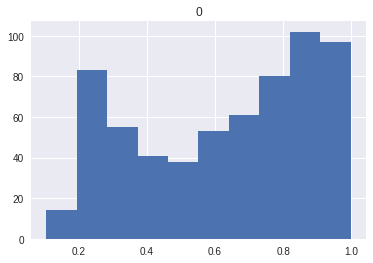

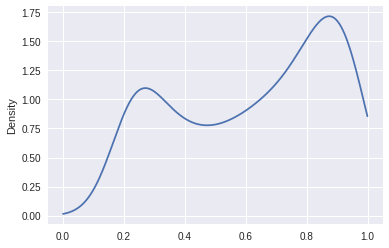

In [0]:
positiveindices= np.where(val_y == 1)
model_final.load_weights(MODEL)
test_positive_predictions =  model_final.predict(val_X[positiveindices])

positivedataframe =  pd.DataFrame(test_positive_predictions)
positivedataframe.hist()
arrange = np.arange(0,1,0.001)
positiveax = positivedataframe.plot.kde(ind = arrange, legend=False)

positiveline = positiveax.lines[0]
positivexdata= positiveline.get_xdata()
positiveydata= positiveline.get_ydata()

def returnprob(xdata, ydata, num):
  index_of_nearest = bisect_left(xdata, num)
  if index_of_nearest == 1000:
    index_of_nearest -=1 
  result = ydata[index_of_nearest]
  return result

returnprob(positivexdata, positiveydata, 0.385)
# positiveydata

0.3218567225693338

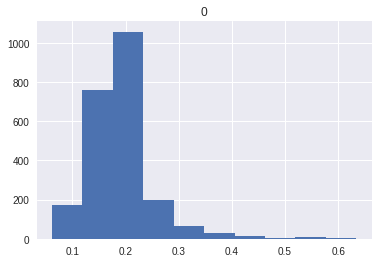

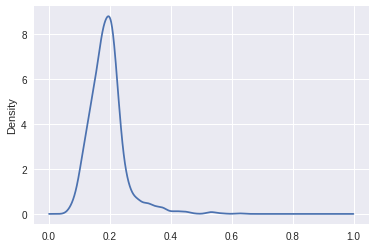

In [0]:
negativeindices= np.where(val_y == 0)
model_final.load_weights(MODEL)
test_negative_predictions =  model_final.predict(val_X[negativeindices])

negativedataframe =  pd.DataFrame(test_negative_predictions)
negativedataframe.hist()
arrange = np.arange(0,1,0.001)
negativeax = negativedataframe.plot.kde(ind= arrange, legend=False)

negativeline = negativeax.lines[0]
negativexdata= negativeline.get_xdata()
negativeydata= negativeline.get_ydata()

returnprob(negativexdata, negativeydata, 0.36)
# negativeindices
# negativexdata.shape
# negativeydata.shape

In [0]:
# # positiveydata[np.where(positiveydata == 0)] = 0.0000001
# # negativeydata[np.where(negativeydata == 0)] = 0.0000001
# hdata  = []
# for i in (positivexdata):
#   hdata += [log(returnprob(positivexdata, positiveydata, i)) - log(returnprob(negativexdata, negativeydata, i))]
# #     log(returnprob(positivexdata, positiveydata, i)) - log(returnprob(negativexdata, negativeydata, i))

# plt.plot(positivexdata, hdata)
# plt.show()

In [0]:
predictions =  model_final.predict(val_X)
prediction_classes=[]
for x in predictions:
  if x> 0.5:
    prediction_classes.append(1)
  else:
    prediction_classes.append(0)

confusion_matrix(val_y, prediction_classes)

array([[2301,   11],
       [ 214,  410]])

In [0]:
import numpy as np
from sklearn.metrics import roc_auc_score
roc_auc_score(val_y, prediction_classes)

0.8261467482920769

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(val_y, prediction_classes)

0.9233651226158038

# Predicting

In [0]:
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt

from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import os
import cv2
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util.montage import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '../input'
train_image_dir = os.path.join(ship_dir, 'train')
test_image_dir = os.path.join(ship_dir, 'test')

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction


def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def fillEmpty(lsst):  
  if len(lsst) == 0:
    return [0.1]
#   elif len(lsst) == 1:
#     return lsst.extend(lsst)
  else:
    return lsst
  
def bayesfunction(lsst):  
  a=0
  for i in lsst:
    a= a+ log(returnprob(positivexdata, positiveydata, i)) - log(returnprob(negativexdata, negativeydata, i))
  return(a)

def thresholdfunction(lsst, threshold):
  if lsst >= threshold:
    return 1
  else:
    return 0
  
def findPredictedBox():
  fig, ax = plt.subplots(figsize = (24,10))
#   img_0 = imread(TESTIMAGE)
  img_0 = testImage.copy()
  mask_0 = heatMap.values
  lbl_0 = label(mask_0) 
  props = regionprops(lbl_0)
  # print ('Image', testImage)
  for prop in props:
    if(abs(prop.bbox[0]-prop.bbox[2]) < 30 or abs(prop.bbox[0]-prop.bbox[2])<30):
      props.remove(prop)
  for prop in props:
    print('Found bbox', prop.bbox)
    cv2.rectangle(img_0, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 3)
  ax.imshow(img_0, cmap= 'gray')
  ax.grid(False)
  plt.show()

  background= np.zeros((testLabel.shape[0], testLabel.shape[1]))
  pdarea = pd.DataFrame(background)

  for prop in props:
    pdarea.iloc[prop.bbox[0]:prop.bbox[2],prop.bbox[1]:prop.bbox[3]] = 1

  return pdarea.values

def findTruthBoxes(testLabel):
  n = 12
  l = 256
  im = testLabel

  im = filters.gaussian_filter(im, sigma= l / (5. * n))
  blobs = im > 0.7 * im.mean()

  all_labels = measure.label(blobs)
  blobs_labels = measure.label(blobs, background=0)

  b, count= np.unique(all_labels, return_counts=True)
  org = np.argwhere(count<250)

  delete= b[org]

  for i in range(0,all_labels.shape[0]):
    for j in range(0,all_labels.shape[1]):
      if all_labels[i][j] in delete:
        all_labels[i][j] = 0

  fig, ax = plt.subplots(figsize = (24,10))
#   img_0 = imread(TESTIMAGE)
  img_0 = testImage.copy()
  mask_0 = all_labels
  lbl_0 = label(mask_0) 
  props = regionprops(lbl_0)
  # print ('Image', testImage)
  for prop in props:
    print('Found bbox', prop.bbox)
    cv2.rectangle(img_0, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 3)
  ax.imshow(img_0, cmap='gray')
  ax.grid(False)
  plt.show()

  background= np.zeros((testLabel.shape[0], testLabel.shape[1]))
  pdback = pd.DataFrame(background)

  for prop in props:
    pdback.iloc[prop.bbox[0]:prop.bbox[2],prop.bbox[1]:prop.bbox[3]] = 1

  return pdback.values

In [0]:
TEST_PATCH_SIZE= 180
TEST_STRIDE = 60

TESTIMAGE = 'W0001/W0001_0005.png'
TESTLABEL = 'W0002/W0002_0005.png'

testImage = imread(TESTIMAGE)
print(testImage.shape)

testLabel = imread(TESTLABEL)

test_pat, test_patclass, test_image_patches, test_label_patches = extractimages(testImage, testLabel, TEST_PATCH_SIZE, TEST_STRIDE)

testImages= np.asarray(test_pat)
testLabels = np.asarray(test_patclass)
print(test_image_patches.shape)

In [0]:
np.array(printTrainImages[0]).shape

01
Threshold:349.14155509878043


/usr/local/lib/python3.6/dist-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):


Found bbox (52, 1018, 322, 3509)
Found bbox (113, 2, 257, 108)
Found bbox (123, 247, 163, 292)
Found bbox (140, 967, 159, 986)
Found bbox (140, 1027, 168, 1062)
Found bbox (141, 809, 162, 830)
Found bbox (153, 250, 225, 332)
Found bbox (154, 538, 256, 1014)
Found bbox (190, 154, 212, 176)
Found bbox (194, 114, 228, 147)
Found bbox (214, 90, 236, 111)
Found bbox (216, 1938, 239, 1962)
Found bbox (219, 2091, 263, 2132)
Found bbox (228, 1988, 251, 2025)
Found bbox (237, 2518, 264, 2543)
Found bbox (240, 1064, 268, 1085)
Found bbox (275, 2038, 308, 2079)
Found bbox (276, 3473, 314, 3509)


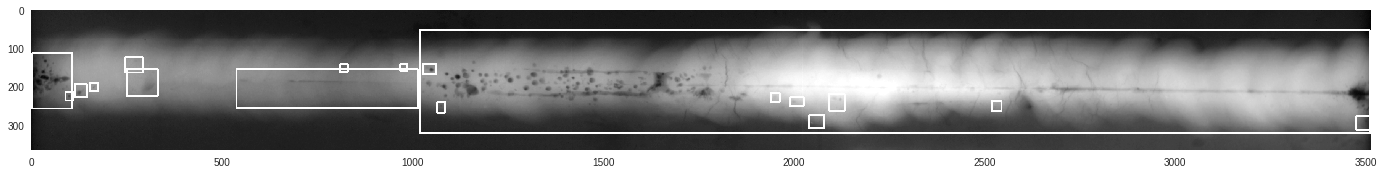

Found bbox (40, 920, 360, 3480)
Found bbox (80, 0, 320, 400)
Found bbox (120, 520, 280, 880)


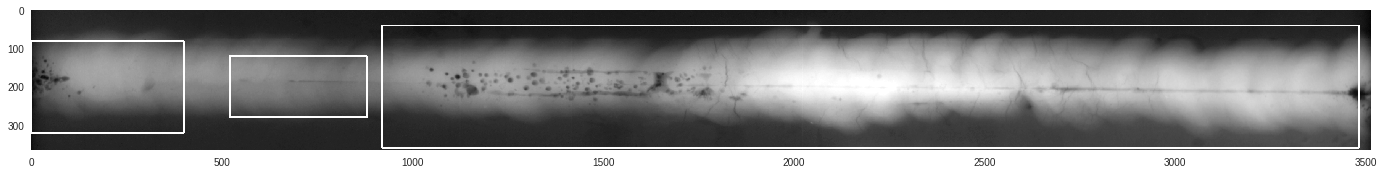

[[[300682. 238829.]
  [ 11910. 733971.]]]
238829.0


In [0]:
MIOUlist =[]
ACClist = []
RecallPositive= []
RecallNegative = []
Precision = []

# for i in range(200,300):
# for i in [ 1,  2,  6,  7,  8,  9, 10, 12, 13, 17, 18, 20, 22, 27, 39, 47, 51, 52, 66, 67]:
# for i in [52, 66]:
# for i in ["01","02","03","04","05"]:
for i in ["01"]:
  print(i) 
  
  ####NEU dataset###
#   testImage = NEUimages[i]
#   testLabel = NEUgroundtruths[i]

#   testImage = imread('Railsurfaceimages/rail_' + str(i) + '.jpg')
#   testLabel = imread('GroundTruth/rail_' + str(i) + '.jpg')
  
  testImage = imread('W0001/W0001_00' + i + '.png')
  testLabel = imread('W0002/W0002_00' + i + '.png')

  test_pat, test_patclass, test_image_patches, test_label_patches = extractimages(testImage, testLabel, PATCH_SIZE, STRIDE_SIZE)
  
#   TESTIMAGE = 'Railsurfaceimages/rail_'+str(i)+'.jpg'
#   TESTLABEL = 'GroundTruth/rail_'+str(i) +'.jpg'
  
#   TESTIMAGE = 'W0001/W0001_00' + i + '.png'
#   TESTLABEL = 'W0002/W0002_00' + i + '.png'

#   print(len(test_pat))
  testImages= np.asarray(test_pat)
  testLabels = np.asarray(test_patclass)
#   print(testImages.shape)
  
  predictions =  model_final.predict(testImages)
# tensorshape = sess.run(image_patches).shape
  predictions = np.reshape(predictions, (test_image_patches.shape[1], test_image_patches.shape[2]))
#   print(predictions.shape)
  
  
  ##### Storing probability in list, showing in dataframe######
  dist = [[[] for j in range(testImage.shape[1])] for i in range(testImage.shape[0])]

  for i in range(0, int(test_image_patches.shape[1])):
    for j in range(0, int(test_image_patches.shape[2])):

      starti=0 + i*STRIDE_SIZE
      startj=0 + j*STRIDE_SIZE

      for x in range(starti, starti+ PATCH_SIZE):
  #       print("x:"+ str(x))
        for y in range(startj, startj+ PATCH_SIZE):
  #         print(y)
          dist[x][y].append(predictions[i][j])

  probaTable = pd.DataFrame(dist)
  # probaTable
  
#   print("reached probaTable")
  ##### fill empty list######
  filledTable = probaTable.copy().applymap(fillEmpty)
  ##### Bayes Fusion######
  BayesTable = filledTable.applymap(bayesfunction)
#   BayesTable.describe()

  ##### Set Threshold######
  THRESHOLD = BayesTable[0].quantile(0.5)
  print("Threshold:" + str(THRESHOLD))
  
  ##### Binarized######
  heatMap =  BayesTable.applymap(lambda x: thresholdfunction(x, THRESHOLD))
  
  ##### find Truth Bounding Box Areas######
  pdback = findTruthBoxes(testLabel)
  
  ##### find Predicted Bounding Box Areas######
  pdarea= findPredictedBox()
  
  with tf.Session() as sess:
    a, b= tf.metrics.mean_iou(tf.convert_to_tensor(pdback), tf.convert_to_tensor(pdarea), 2)
  #   print(b)
    sess.run(tf.local_variables_initializer())
    confusionMatrix= np.asarray(sess.run([b]))
    miou =sess.run([a])
    print(confusionMatrix)
#     print(miou)
    MIOUlist +=[miou]

    accuracy = (confusionMatrix[0,0,0] + confusionMatrix[0,1,1])/ (confusionMatrix[0,0,0] + confusionMatrix[0,0,1]  + confusionMatrix[0,1,0]  + confusionMatrix[0,1,1])
    ACClist +=[accuracy]
    
    recallPos = (confusionMatrix[0,1,1])/ (confusionMatrix[0,1,0]  + confusionMatrix[0,1,1])
    RecallPositive +=[recallPos]
    
    recallNeg = (confusionMatrix[0,0,0])/ (confusionMatrix[0,0,0]  + confusionMatrix[0,0,1])
    RecallNegative +=[recallNeg]
    
    precision = (confusionMatrix[0,1,1])/ (confusionMatrix[0,1,1]  + confusionMatrix[0,0,1])
    Precision +=[precision]
    print(confusionMatrix[0,0,1])

In [0]:
print(MIOUlist)
np.mean(MIOUlist)

[[0.76616156]]


0.76616156

In [0]:
print(RecallPositive)
np.mean(RecallPositive)

[0.8495644747620599]


0.8495644747620599

In [0]:
print(RecallNegative)
np.mean(RecallNegative)

[0.8963394629581232]


0.8963394629581232

In [0]:
print(Precision)
np.mean(Precision)

[0.9189008120649652]


0.9189008120649652

In [0]:
print(ACClist)
np.mean(ACClist)

[0.8691971009621967]


0.8691971009621967

In [0]:
print("printtillhere -leftfor badminton")

In [0]:
probaTable.head()

In [0]:
filledTable.head()

In [0]:
returnprob(positivexdata, positiveydata, 0.3)
returnprob(negativexdata, negativeydata, 0.3)

In [0]:
img_0 = imread(TESTIMAGE)
print(testImage.shape)

fig, ax = plt.subplots(figsize = (24,10))

for iidx, i in enumerate(range(0, testImage.shape[0]-PATCH_SIZE, STRIDE_SIZE)):
#   print(i)
  for jidx, j in enumerate(range(0, testImage.shape[1]-PATCH_SIZE, STRIDE_SIZE)) :
#     print(jidx)
    if(predictions[iidx][jidx] > 0.5):
      cv2.rectangle(img_0, (j, i), (j+PATCH_SIZE, i+PATCH_SIZE), (255, 0, 0), 3)

ax.imshow(img_0, cmap = 'gray')
ax.grid(False)

In [0]:
fig, ax = plt.subplots(figsize=(24, 10))
ax.imshow(heatMap.values, interpolation='nearest')
ax.grid(False)
plt.tight_layout()

In [0]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(testLabel, interpolation='nearest')
plt.tight_layout()

In [0]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(testImage, interpolation='nearest')
plt.tight_layout()

In [0]:
plt.figure(figsize=(24,10))
plt.imshow(pdarea)
plt.grid(False)

In [0]:
def findPredictedBox():
  fig, ax = plt.subplots(figsize = (24,10))
  img_0 = imread(TESTIMAGE)
  mask_0 = heatMap.values
  lbl_0 = label(mask_0) 
  props = regionprops(lbl_0)
  # print ('Image', testImage)
  for prop in props:
    if(abs(prop.bbox[0]-prop.bbox[2]) < 30 or abs(prop.bbox[0]-prop.bbox[2])<30):
      props.remove(prop)
  for prop in props:
    print('Found bbox', prop.bbox)
    cv2.rectangle(img_0, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 3)
  ax.imshow(img_0, cmap= 'gray')
  ax.grid(False)
  plt.show()

  background= np.zeros((testLabel.shape[0], testLabel.shape[1]))
  pdarea = pd.DataFrame(background)

  for prop in props:
    pdarea.iloc[prop.bbox[0]:prop.bbox[2],prop.bbox[1]:prop.bbox[3]] = 1

  return pdarea.values

In [0]:
fig, ax = plt.subplots(figsize = (24,10))

img_0 = imread(TESTLABEL)
mask_0 = testLabel
lbl_0 = label(mask_0) 
props = regionprops(lbl_0)
# print ('Image', testImage)
for prop in props:
  print('Found bbox', prop.bbox)
  cv2.rectangle(img_0, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 3)
ax.imshow(img_0)
ax.grid(False)
# ax.imshow(img_1)
#     ax1.set_title('Image')
#     ax2.set_title('Mask')
#     ax3.set_title('Image with derived bounding box')
#     ax2.imshow(mask_0[...,0], cmap='gray')
#     ax3.imshow(img_1)
plt.show()

In [0]:
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np

def findTruthBoxes(testLabel):
  n = 12
  l = 256
  im = testLabel

  im = filters.gaussian_filter(im, sigma= l / (5. * n))
  blobs = im > 0.7 * im.mean()

  all_labels = measure.label(blobs)
  blobs_labels = measure.label(blobs, background=0)

  b, count= np.unique(all_labels, return_counts=True)
  org = np.argwhere(count<250)

  delete= b[org]

  for i in range(0,all_labels.shape[0]):
    for j in range(0,all_labels.shape[1]):
      if all_labels[i][j] in delete:
        all_labels[i][j] = 0

  fig, ax = plt.subplots(figsize = (24,10))
  img_0 = imread(TESTIMAGE)
  mask_0 = all_labels
  lbl_0 = label(mask_0) 
  props = regionprops(lbl_0)
  # print ('Image', testImage)
  for prop in props:
    print('Found bbox', prop.bbox)
    cv2.rectangle(img_0, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 3)
  ax.imshow(img_0, cmap='gray')
  ax.grid(False)
  plt.show()

  background= np.zeros((testLabel.shape[0], testLabel.shape[1]))
  pdback = pd.DataFrame(background)

  for prop in props:
    pdback.iloc[prop.bbox[0]:prop.bbox[2],prop.bbox[1]:prop.bbox[3]] = 1

  return pdback.values

In [0]:
background= np.zeros((testLabel.shape[0], testLabel.shape[1]))
background.shape
pdback = pd.DataFrame(background)

for prop in props:
  pdback.iloc[prop.bbox[0]:prop.bbox[2],prop.bbox[1]:prop.bbox[3]] = 1
#   print('Found bbox', prop.bbox)


# print(props[0].bbox)
# pdback.iloc[props[0].bbox[0]:props[0].bbox[2],props[0].bbox[1]:props[0].bbox[3]] = 1

plt.figure(figsize=(24,10))
plt.imshow(pdback.values)
plt.grid(False)

In [0]:
with tf.Session() as sess:
  a, b= tf.metrics.mean_iou(tf.convert_to_tensor(pdback), tf.convert_to_tensor(heatMap.values), 2)
#   print(b)
  sess.run(tf.local_variables_initializer())
  confusionMatrix= np.asarray(sess.run([b]))
  miou =sess.run([a])
  print(confusionMatrix)
  print(miou)
  accuracy = (confusionMatrix[0,0,0] + confusionMatrix[0,1,1])/ (confusionMatrix[0,0,0] + confusionMatrix[0,0,1]  + confusionMatrix[0,1,0]  + confusionMatrix[0,1,1])
  print(accuracy)